                       Layer  log2(scale)  mean log2(|w|)  median log2(|w|)  energy-weighted mean log2(|w|)  calculated log2(scale)  exact_match
                     lm_head            4       -5.093126         -4.765753                       -3.530871                       4         True
 transformer.h.0.attn.c_attn            4       -5.261907         -4.967301                       -3.399266                       3        False
 transformer.h.0.attn.c_proj            4       -6.076171         -5.764338                       -4.305929                       4         True
    transformer.h.0.mlp.c_fc            4       -5.343068         -5.001962                       -3.843798                       4         True
  transformer.h.0.mlp.c_proj            4       -5.964895         -5.624296                       -4.345857                       4         True
 transformer.h.1.attn.c_attn            4       -5.380560         -5.095073                       -3.539464                       

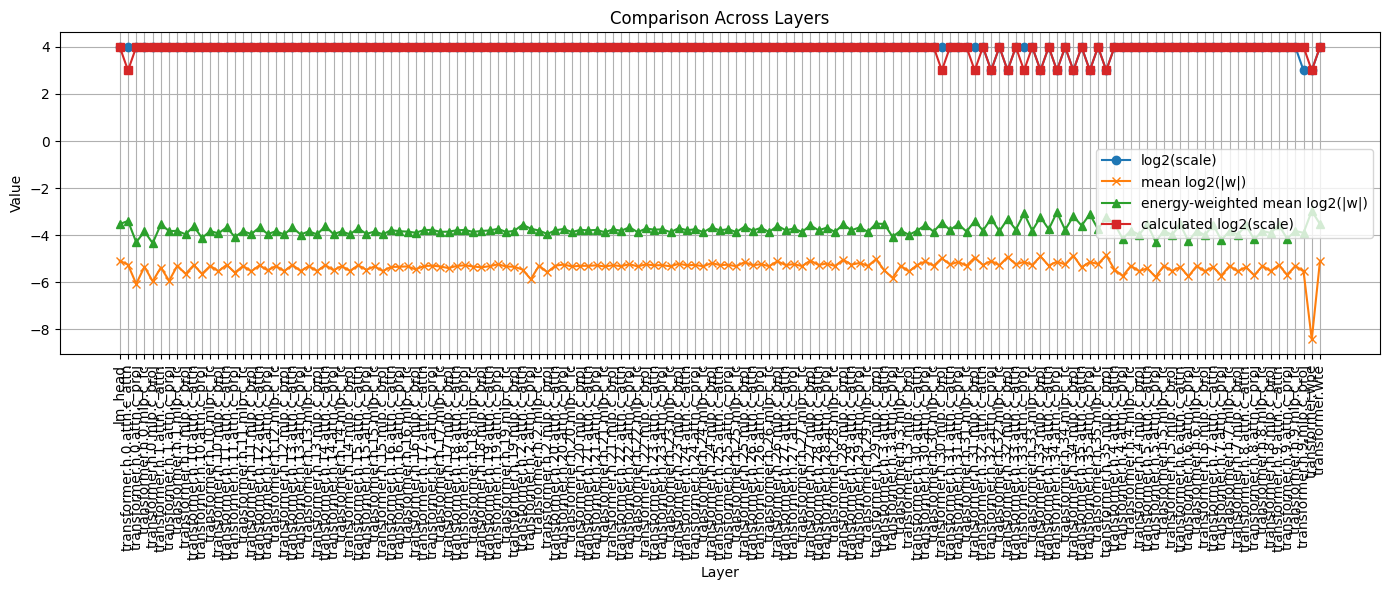

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load saved stats
with open("posit_quantization_log.json", "r") as f:
    quant_log = json.load(f)

with open("layer_weight_stats.json", "r") as f:
    weight_stats = json.load(f)

# Collect stats into a list of dictionaries
records = []
for name in sorted(set(quant_log.keys()) | set(weight_stats.keys())):
    q = quant_log.get(name, {})
    s = weight_stats.get(name, {})

    log2_scale = q.get("log2_scale")
    ew_mean = s.get("energy_weighted_mean_log2_abs_weight")
    # calc_log2_scale = -int(np.floor(ew_mean)) if ew_mean is not None else None
    calc_log2_scale = -int(round(ew_mean)) if ew_mean is not None else None

    match = (log2_scale == calc_log2_scale) if None not in (log2_scale, calc_log2_scale) else False

    records.append({
        "Layer": name,
        "log2(scale)": log2_scale,
        "mean log2(|w|)": s.get("mean_log2_abs_weight"),
        "median log2(|w|)": s.get("median_log2_abs_weight"),
        "energy-weighted mean log2(|w|)": ew_mean,
        "calculated log2(scale)": calc_log2_scale,
        "exact_match": match
    })

# Convert to DataFrame
df = pd.DataFrame(records)

# Print full table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
print(df.to_string(index=False))

# Print total exact matches
match_count = df["exact_match"].sum()
print(f"\nTotal exact matches: {match_count} / {len(df)}")

# ---- Plotting ----
df_plot = df.dropna()
df_plot = df_plot.sort_values("Layer")

x = list(df_plot["Layer"])
y1 = df_plot["log2(scale)"]                      # Not negated
y2 = df_plot["mean log2(|w|)"]
y3 = df_plot["energy-weighted mean log2(|w|)"]
y4 = df_plot["calculated log2(scale)"]

plt.figure(figsize=(14, 6))
plt.plot(x, y1, label='log2(scale)', marker='o')
plt.plot(x, y2, label='mean log2(|w|)', marker='x')
plt.plot(x, y3, label='energy-weighted mean log2(|w|)', marker='^')
plt.plot(x, y4, label='calculated log2(scale)', marker='s')
plt.xticks(rotation=90)
plt.xlabel("Layer")
plt.ylabel("Value")
plt.title("Comparison Across Layers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
